# CNN Video Subnet Model

In this model, the video subnet is using a simple CNN network with 2 Conv layers and 1 Fc layer.

In [1]:
from ipynb.fs.full.DataProcessUtils import readDataSet
import tensorflow as tf
import numpy as np
import gc
import matplotlib.pyplot as plt
from IPython import display

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Setting & Init

In [2]:
train_size = 90
dev_size = 10
total_loading = train_size + dev_size

iteration = 10000
learning_rate = 2*10**-5

In [3]:
data = readDataSet("../data/5s_clips", 48000, total_loading)

----- executing ------
001253.mp4
----- succeeded -------
----- executing ------
004693.mp4
----- succeeded -------
----- executing ------
005155.mp4
----- succeeded -------
----- executing ------
002493.mp4
----- succeeded -------
----- executing ------
001683.mp4
----- succeeded -------
----- executing ------
000228.mp4
----- succeeded -------
----- executing ------
006650.mp4
----- succeeded -------
----- executing ------
005731.mp4
----- succeeded -------
----- executing ------
005704.mp4
----- succeeded -------
----- executing ------
004655.mp4
----- succeeded -------
----- executing ------
008351.mp4
----- succeeded -------
----- executing ------
000502.mp4
----- succeeded -------
----- executing ------
003609.mp4
----- succeeded -------
----- executing ------
003201.mp4
----- succeeded -------
----- executing ------
000439.mp4
----- succeeded -------
----- executing ------
001634.mp4
----- succeeded -------
----- executing ------
001574.mp4
----- succeeded -------
----- executin

## Utils

In [4]:
def get_variable(name, shape, alpha=0.01):
    initial = alpha * tf.random_normal(shape)
    return tf.Variable(initial, name=name)

In [5]:
def get_optimizer(labels, logits, learning_rate = 10**-7):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam').minimize(loss)
    return loss, optimizer

In [6]:
def get_accuracy(labels, logits):
    prediction = tf.cast(tf.greater(logits, 0.5), dtype=tf.float32)
    correct = tf.equal(labels, prediction)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    return accuracy

## Video Subnet

In [7]:
def video_subnet(X, parameters):
    # This video sub net is a simple 3-layer CNN
    # Conv --> ReLU --> MaxPool --> Conv --> ReLU --> MaxPool --> FC
    
    W1 = parameters['v_w1']  # --> [5, 5, 3, 16]
    W2 = parameters['v_w2']  # --> [5, 5, 16, 32]
    v_features = parameters['v_features']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 2, 2, 1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 2, 2, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, v_features, activation_fn=None)

    return Z3

In [8]:
def video_model(parameters):
    # this is a helper function to propogate the CNN to all frames in a video clip
    # [None, frame, height, width, depth] --> [None, frame, v_features] 
    def video_model_1(x):
        return video_subnet(x, parameters)
    return video_model_1

## Audio Subnet

In [9]:
def audio_subnet(x, parameters):
    # this is a simple 1-layer NN
    w = parameters['a_w']
    b = parameters['a_b']
    
    P0 = tf.reshape(x, [-1, 1])
    Z1 = tf.add(tf.matmul(w, P0), b)
    A1 = tf.nn.relu(Z1)
    
    return A1

In [10]:
def audio_fn(parameters):
    # this is a helper function to propagate the NN to all frames in a audio source
    def audio_fn_1(x):
        return tf.reshape(audio_subnet(x, parameters), [-1])
    return audio_fn_1

In [11]:
def audio_model(parameters):
    # this is a helper function to propagate the NN to all audios in a collection
    # [None, frame, height, width] --> [None, frame, a_features] 
    def audio_model_1(x):
        return tf.map_fn(audio_fn(parameters), x)
    return audio_model_1

## Rnn

In [12]:
def rnn_model(x, parameters, rnn_size, width, height):
    w = parameters['r_w']
    b = parameters['r_b']
    
    # LSTM
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_size, reuse=False)
    
    # D0 is the number of pictures, here we want to split the pictures into sequences of lines
    # this transpose would make row number the 1st dimension
    x = tf.transpose(x, [1, 0, 2])
    
    # reshape to make the tensor in shape [ROW * #_OF_PICS, COL]
    x = tf.reshape(x, [-1, width])
    
    # split the tensor into ROW groups, each group has shape [#_OF_PICS, COL]
    # so group 1 contains row 1 from all pics, group 2 contains row 2 from all pics
    x = tf.split(x, height)
    
    # get the outputs, which would be the last output from LSTM
    outputs, status = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32, scope=tf.get_variable_scope())
    logits = tf.add(tf.matmul(outputs[-1], w), b)

    return logits

## Main Model

In [13]:
def cs230_model(frames, v, v_height, v_width, v_features, a, a_height, a_width, a_features, rnn_size):
    parameters = {}
    
    vw1 = get_variable('video_w1', [5, 5, 3, 16])
    vw2 = get_variable('video_w2', [5, 5, 16, 32])
    aw = get_variable('audio_w', [a_features, a_height * a_width])
    ab = get_variable('audio_b', [a_features, 1])
    rw = get_variable('rnn_w', [rnn_size, 1])
    rb = get_variable('rnn_b', [1])
    
    parameters['v_w1'] = vw1
    parameters['v_w2'] = vw2
    parameters['a_w'] = aw
    parameters['a_b'] = ab
    parameters['r_w'] = rw
    parameters['r_b'] = rb
    parameters['v_features'] = v_features
    
    v_out = tf.map_fn(video_model(parameters), v, name='video_features') # --> [None, frames, v_features]
    a_out = tf.map_fn(audio_model(parameters), a, name='audio_features') # --> [None, frames, a_features]
    
    c = tf.concat([v_out, a_out], axis=2, name='concat_features')     # --> [None, frames, v_features + a_features]
    tf.summary.tensor_summary('concat', c)
    
    logits = rnn_model(c, parameters, rnn_size, v_features + a_features, frames)
    
    return logits

In [14]:
def test_train(iteration):
    data = readDataSet("../data/5s_clips", 48000, 2)
    
    videos = np.asarray([d[1] for d in data])
    audios = np.asarray([d[2] for d in data])
    
    frames, v_height, v_width, dummy_0 = videos[0].shape
    dummy_0, a_height, a_width = audios[0].shape
    
    y_truth = np.asarray([[0], [1]])
    y = tf.placeholder(tf.float32, [None, 1])
    v = tf.placeholder(tf.float32, [None, frames, v_height, v_width, 3])
    a = tf.placeholder(tf.float32, [None, frames, a_height, a_width])
    y_hat = cs230_model(frames, v, v_height, v_width, 32, a, a_height, a_width, 16, 32)
    
    los, opt = get_optimizer(y, y_hat)
    acc = get_accuracy(y, y_hat)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # reset tf
    tf.reset_default_graph()
    
    # summary part
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/cnn_video_subnet_model_test/train', sess.graph)
    
    for i in range(iteration):
        loss, dummy_0, accuracy = sess.run([los, opt, acc], feed_dict={v: videos, a: audios, y:y_truth})
        print(str(i) + " loss: " + str(loss) + " accuracy: " + str(accuracy))
        # train_writer.add_summary(summary, i)

In [15]:
# test_train(10)

In [16]:
def test_train_alignment(iteration, train_size, dev_size, data):
    train_half = train_size // 2
    dev_half = dev_size // 2
    total = train_size + dev_size
    
    videos = [d[1] for d in data]
    audios = [d[2][:, :, :] for d in data]
    
    v_train_clips = videos[:train_size]
    a_train_clips = audios[:train_size]
    v_dev_clips = videos[train_size:total]
    a_dev_clips = audios[train_size:total]
    
    for i in range(train_half):
        # cut the first 96 frames
        v_train_clips[i] = np.asarray(v_train_clips[i][:96, :, :, :])
        a_train_clips[i] = np.asarray(a_train_clips[i][:96, :, :])
        # shift the audio of second half of trainning data by half second
        v_train_clips[i + train_half] = np.asarray(v_train_clips[i + train_half][:96, :, :, :])
        a_train_clips[i + train_half] = np.asarray(a_train_clips[i + train_half][12:108, :, :])
        
    # for i in range(train_size):
    #     print(v_train_clips[i].shape)
    #     print(a_train_clips[i].shape)
    
    y_train = np.reshape(np.asarray([1 - (i // train_half) for i in range(train_size)], dtype=np.float), (train_size, 1))
    v_train = np.asarray(v_train_clips, dtype=np.float) + 0
    a_train = np.asarray(a_train_clips, dtype=np.float) + 0
    
    # for i in range(2):
    #     for j in range(96):
    #         for k in range(129):
    #             print(str(i) + "." + str(j) + "." + str(k) + ":" + str(a_train[i][j][k]))
    
    for i in range(dev_half):
        # cut the first 96 frames
        v_dev_clips[i] = v_dev_clips[i][:96, :, :, :]
        a_dev_clips[i] = a_dev_clips[i][:96, :, :]
        # shift the audio of second half of trainning data by half second
        v_dev_clips[i + dev_half] = v_dev_clips[i + dev_half][:96, :, :, :]
        a_dev_clips[i + dev_half] = a_dev_clips[i + dev_half][12:108, :, :]
    
    # for i in range(dev_size):
    #     print(v_dev_clips[i].shape)
    #     print(a_dev_clips[i].shape)
    
    y_dev = np.reshape(np.asarray([1 - (i // dev_half) for i in range(dev_size)], dtype=np.float), (dev_size, 1))
    v_dev = np.array(v_dev_clips, dtype=np.float)
    a_dev = np.array(a_dev_clips, dtype=np.float)
    
    frames, v_height, v_width, dummy_0 = v_train[0].shape
    dummy_0, a_height, a_width = a_train[0].shape
    
    yy = tf.placeholder(tf.float32, [None, 1], name="y")
    vv = tf.placeholder(tf.float32, [None, frames, v_height, v_width, 3], name="videos")
    aa = tf.placeholder(tf.float32, [None, frames, a_height, a_width], name="audios")
    y_hat = cs230_model(frames, vv, v_height, v_width, 32, aa, a_height, a_width, 16, 32)
    
    los, opt = get_optimizer(yy, y_hat, 2*10**-5)
    acc = get_accuracy(yy, y_hat)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # summary part
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/cnn_video_subnet_model_alignment/train', sess.graph)
    
    tf.reset_default_graph()
    
    # record loss and accuracy
    loss_i = []
    loss_graph = []
    # dev accuracy
    dev_acc_i = []
    dev_acc_graph = []
    dev_acc = sess.run([acc], feed_dict={vv:v_dev, aa:a_dev, yy:y_dev})
    dev_acc_graph.append(dev_acc)
    dev_acc_i.append(0)
    # train accuracy
    train_acc_i = []
    train_acc_graph = []
    train_acc = sess.run([acc], feed_dict={vv:v_train, aa:a_train, yy:y_train})
    train_acc_graph.append(train_acc)
    train_acc_i.append(0)
    # set up plot
    plt.plot(loss_i, loss_graph, color='blue', label='train_loss')
    plt.plot(dev_acc_i, dev_acc_graph, color='red', label='dev_acc')
    plt.plot(train_acc_i, train_acc_graph, color='yellow', linestyle='dashed', label='train_acc')
    plt.legend()
    display.display(plt.gcf())
    display.clear_output(wait=True)

    try:
        for i in range(iteration):
            loss, dummy_0 = sess.run([los, opt], feed_dict={vv:v_train, aa:a_train, yy:y_train})
            # record loss
            loss_graph.append(loss)
            loss_i.append(i)
            if i % 20 == 19:
                # run the dev set every 20 iterations
                dev_acc = sess.run([acc], feed_dict={vv:v_dev, aa:a_dev, yy:y_dev})
                dev_acc_graph.append(dev_acc)
                dev_acc_i.append(i)
                # also get the training set accuracy
                train_acc = sess.run([acc], feed_dict={vv:v_train, aa:a_train, yy:y_train})
                train_acc_graph.append(train_acc)
                train_acc_i.append(i)
                
                # plot three lines for loss, dev_acc and train_acc
                plt.plot(loss_i, loss_graph, color='blue', label='train_loss')
                plt.plot(dev_acc_i, dev_acc_graph, color='red', label='dev_acc')
                plt.plot(train_acc_i, train_acc_graph, color='yellow', linestyle='dashed', label='train_acc')
                display.display(plt.gcf())
                display.clear_output(wait=True)
            # train_writer.add_summary(summary, i)
    finally:
        sess.close()

KeyboardInterrupt: 

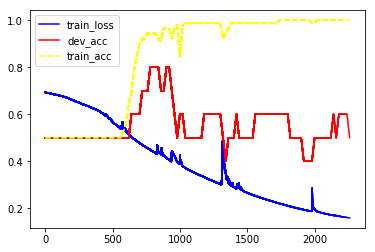

In [17]:
test_train_alignment(iteration, train_size, dev_size, data)
gc.collect()

In [ ]:
for i in range(500):
    print(data[i][1].shape)

In [ ]:
a = tf.constant(
    [
        [
            [
                [[1, 2], [3, 4]], [[5, 6], [7, 8]]
            ], 
            [
                [[9, 10], [11, 12]], [[13, 14], [15, 16]]
            ], 
            [
                [[17, 18], [19, 20]], [[21, 22], [23, 24]]
            ]
        ],
        [
            [
                [[1, 2], [3, 4]], [[5, 6], [7, 8]]
            ], 
            [
                [[9, 10], [11, 12]], [[13, 14], [15, 16]]
            ], 
            [
                [[17, 18], [19, 20]], [[21, 22], [23, 24]]
            ]
        ]
    ]
)
b = tf.constant(
    [
        [
            [
                [1, 2], [3, 4]
            ], 
            [
                [9, 10], [11, 12]
            ], 
            [
                [17, 18], [19, 20]
            ]
        ],
        [
            [
                [1, 2], [3, 4]
            ], 
            [
                [9, 10], [11, 12]
            ], 
            [
                [17, 18], [19, 20]
            ]
        ]
    ]
)

In [ ]:
d = tf.reshape(a, [-1])

In [ ]:
ww1 = tf.constant([[1, 2, 1, 2, 1, 2, 1, 2], [1, 2, 1, 2, 1, 2, 1, 2]])
ww2 = tf.constant([[1, 2, 3, 4]])
bb1 = tf.constant([[1], [2]])
bb2 = tf.constant([1])
oo1 = tf.map_fn(video_model(ww1, bb1), a)
oo2 = tf.map_fn(video_model(ww2, bb2), b)
cc = tf.concat([oo1, oo2], axis=2)
ss = tf.shape(cc)
sa = tf.shape(oo1)
sb = tf.shape(oo2)

In [ ]:
sess = tf.Session()

In [ ]:
sess.run(cc)

In [ ]:
sess.run(cc)